In [14]:
import matplotlib.pyplot as plt
import pandas as pd


def make_long(df: pd.DataFrame, group: str) -> pd.DataFrame:
    rep_date_pairs = [
        ('Anzahl der Wiederholung 1', 'Datum 1'),
        ('Anzahl der Wiederholung 2', 'Datum 2'),
        ('Anzahl der Wiederholung 3', 'Datum 3'),
        ('Anzahl der Wiederholung 4', 'Datum 4'),
    ]

    records = []

    for rep_col, date_col in rep_date_pairs:
        for idx, row in df.iterrows():
            name = row['Name']
            repetitions = row[rep_col]
            date = row[date_col]

            if pd.notnull(repetitions):
                trial_info = f"{date.strip()}2025"
                records.append((name, repetitions, trial_info))

    # Create the long-format DataFrame
    df_long = pd.DataFrame(records, columns=['Name', 'Repetitions', 'TrialInfo'])

    # Add continuous trial index per participant
    df_long['TrialIndex'] = df_long.groupby('Name').cumcount() + 1

    # Reorder columns
    df_result = df_long[['Name', 'TrialIndex', 'Repetitions', 'TrialInfo']]
    df_result = df_result.rename(columns={"Name": "ID"})

    # Convert ID to int and Repetitions to float
    df_result["ID"] = df_result["ID"].str.extract(r"(\d+)").astype(int)
    df_result["Repetitions"] = df_result["Repetitions"].astype(float)

    # Convert the TrialInfo column to datetim
    df_result["TrialInfo"] = pd.to_datetime(df_result["TrialInfo"], format="%d.%m.%Y")

    # Instead of having the date in the TrialInfo column. All I need is a number that tells me, this is the first, second third or  fourth encounter.
    # So I will convert the TrialInfo column to a number that tells me the order of the trials.
    date_to_number_map = {
        "kontrollgruppe": {
            "26.02.2025": 1,
            "05.03.2025": 2,
            "12.03.2025": 3,
            "19.03.2025": 4,
        },
        "RL 7e": {
            "11.02.2025": 1,
            "18.02.2025": 2,
            "25.02.2025": 3,
            "04.03.2025": 4,
        },
        "RL 7f": {
            "05.03.2025": 1,
            "12.03.2025": 2,
            "19.03.2025": 3,
            "26.03.2025": 4,
        },
    }
    df_result["TrialInfo"] = df_result["TrialInfo"].dt.strftime("%d.%m.%Y")
    df_result["TrialInfo"] = df_result["TrialInfo"].map(date_to_number_map[group])

    # sprt by ID and TrialIndex
    df_result = df_result.sort_values(by=["ID", "TrialInfo"])

    return df_result.copy()


def transform_VR_in_long(sheet: int, group="VR") -> pd.DataFrame:
    if sheet == 0:
        df = pd.read_csv("./data/Tischtennis.csv")
    else:
        df = pd.read_csv("./data/TischTennisSeite.csv")

    df['Date'] = pd.to_datetime(df['Date'].str.strip())
    df['DayOnly'] = df['Date'].dt.date

    # Sort to ensure we take the last 5 entries per day per participant
    df = df.sort_values(by=['ID', 'DayOnly', 'Date'])

    # Take last 5 entries per participant per day
    df_filtered = df.groupby(['ID', 'DayOnly']).tail(5)

    # Add TrialIndex
    df_filtered = df_filtered.sort_values(by=['ID', 'Date'])

    # remove rows where ID == -1
    df_filtered = df_filtered[~(df_filtered == -1).any(axis=1)].reset_index(drop=True)

    df_filtered['TrialIndex'] = df_filtered.groupby('ID').cumcount() + 1

    # Add TrialInfo: number each unique date per participant
    date_to_number_map = {
        "2025-02-12": 1,
        "2025-02-13": 1,
        "2025-02-19": 2,
        "2025-02-20": 2,
        "2025-02-26": 3,
        "2025-02-27": 3,
        "2025-03-05": 4,
        "2025-03-06": 4,
    }

    # replace date with number
    df_filtered['TrialInfo'] = df_filtered['DayOnly'].astype(str).map(date_to_number_map)

    # Rename Points to Repetitions
    df_filtered = df_filtered.rename(columns={'Points': 'Repetitions'})

    # Add Group column
    df_filtered['Group'] = group

    # Reorder columns
    df_final = df_filtered[['ID', 'TrialIndex', 'Repetitions', 'TrialInfo', 'Group']]

    # print amount of unique IDs:
    print("Unique IDs after loading: ", df_final["ID"].nunique())
    return df_final.copy()


def plot_trialcount(df_long: pd.DataFrame, group: str, sheet: int):
    df_long = df_long.sort_values(by=["ID", "TrialIndex"])
    df_counts = df_long.groupby("ID").size().reset_index(name="TrialCount")

    # plot the df_counts as a bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(df_counts["ID"], df_counts["TrialCount"], color="#009fe3")
    # Add grid lines
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # y ticks should only be 5, 10, 15 or 20
    y_ticks = [i for i in range(0, df_counts["TrialCount"].max() + 1, 5)]
    plt.yticks(y_ticks)

    # Set x ticks to be the ID of the participant
    plt.xticks(df_counts["ID"], df_counts["ID"], rotation=90)

    # Add labels and title
    plt.title(f"{group}: Anzahl der Versuche pro Teilnehmenden Übung {sheet + 1}", fontsize=14, fontweight='bold',
              pad=20)
    plt.xlabel("ID des Teilnehmenden", labelpad=20)
    plt.ylabel("Anzahl der Versuche", labelpad=20)
    plt.tight_layout()

    plt.savefig(f"figures/{group}_trial_count_exercise_{sheet + 1}.png", dpi=300)


def plot_results(df: pd.DataFrame, sheet: int):
    df["Group"] = df["Group"].replace({"RL 7e": "RL", "RL 7f": "RL"})

    for group_name in df.Group.unique():
        df_group = df[df["Group"] == group_name]

        df_plot = df_group.groupby(["ID", "TrialInfo"]).agg(
            Repetitions_mean=("Repetitions", "mean"),
            Repetitions_std=("Repetitions", "std")
        ).reset_index()

        plt.figure(figsize=(12, 6))
        # Plot each participant's data
        for participant_id, group in df_plot.groupby("ID"):
            # If the participant has no results for each trialInfo, the alpha color of the line should be 0.5. In addition, the line should be gray and the marker should be gray. The line should be dashed. The id should not be shown in the legend. It should not have markers.
            if len(group) < len(df_plot["TrialInfo"].unique()):
                plt.plot(group["TrialInfo"], group["Repetitions_mean"], linestyle='--', color='gray', alpha=0.20,
                         label="_nolegend_")
            else:
                plt.plot(group["TrialInfo"], group["Repetitions_mean"], marker='x', label=participant_id)

        # The x ticks should only have the unique values of TrialInfo. TrialInfo is a number that tells me the order of the trials.
        unique_dates = df_plot["TrialInfo"].unique()
        plt.xticks(unique_dates, unique_dates)

        # The y ticks should be in 10 steps
        if sheet == 0:
            y_ticks = [i for i in range(0, int(df_plot["Repetitions_mean"].max()) + 20, 10)]
            plt.yticks(y_ticks)

        # Add grid lines
        plt.grid(axis='y', linestyle='--', alpha=0.1)
        # Add labels and title
        plot_str = "KG" if group_name == "kontrollgruppe" else group_name
        plt.title(f"{plot_str}: Anzahl der Wiederholungen pro Versuch für Übung {sheet + 1}", fontsize=14,
                  fontweight='bold', pad=20)
        plt.xlabel("Messzeitpunkt", labelpad=20)
        plt.ylabel("Anzahl der Wiederholungen", labelpad=20)
        plt.legend(
            title="ID",
            loc="upper center",
            bbox_to_anchor=(0.5, -0.25),
            ncol=11,  # Adjust depending on how many columns you want
            fontsize=8,
            title_fontsize=10
        )
        plt.tight_layout()
        name = group_name.replace(" ", "_").capitalize()
        plt.savefig(f"figures/Übung {sheet + 1}/{name}_repetitions_exercise_{sheet + 1}.png", dpi=300)


def get_valid_ids(df: pd.DataFrame) -> pd.DataFrame:
    valid_ids = (
        df.groupby("ID")["TrialInfo"]
        .nunique()
        .loc[lambda x: x == 4]  # Only keep IDs with all 4 unique TrialInfo values
        .index
    )

    # Step 2: Filter the original dataframe
    filtered_df = df[df["ID"].isin(valid_ids)]

    df_valid = filtered_df.reset_index(drop=True)
    return df_valid.copy()


def plot_improvement_over_time(df: pd.DataFrame, sheet: int):
    df["Group"] = df["Group"].replace({"RL 7e": "RL", "RL 7f": "RL"})
    df_valid = get_valid_ids(df)

    df_days = df_valid.groupby(["ID", "TrialInfo"]).agg(
        Mean_Repetitions=("Repetitions", "mean"),
        Group=("Group", "first"),
        Gender=("Gender", "first")
    ).reset_index()

    # Pivot to wide format with Gender in index
    df_pivot = df_days.pivot(index=["ID", "Group", "Gender"], columns="TrialInfo",
                             values="Mean_Repetitions").reset_index()
    df_pivot.columns.name = None
    df_pivot = df_pivot.rename(columns={1: "Day1", 2: "Day2", 3: "Day3", 4: "Day4"})

    days = ["Day1", "Day2", "Day3", "Day4"]
    x = range(1, 5)

    plt.figure(figsize=(12, 6))
    plt.xticks(x)

    groups = df_pivot["Group"].unique()
    genders = df_pivot["Gender"].unique()

    color_map = {
        "VR": "tab:blue",
        "RL": "tab:orange",
        "Kontrollgruppe": "tab:green"
    }
    alpha_map = {
        "m": 0.5,  # solid
        "w": 0.5  # lighter
    }
    linestyle_map = {
        "m": "--",  # solid
        "w": "--"  # dashed
    }
    marker_map = {
        "m": "o",  # solid
        "w": "d"  # dashed
    }

    # Plot group-level means (all genders combined)
    for group in groups:
        group_data = df_pivot[df_pivot["Group"] == group]
        if group_data.empty:
            continue
        group_means = group_data[days].mean()
        group_stds = group_data[days].std()

        group_str = "KG" if group == "Kontrollgruppe" else group.upper()

        print(f"{group_str} (gesamt)")
        print(f"#Teilnehmer gesamt:", len(group_data))
        print(f"Messzeitpunkt 1: {round(group_means.iloc[0], 3)} +- {round(group_stds.iloc[0], 3)}")
        print(f"Messzeitpunkt 4: {round(group_means.iloc[3], 3)} +- {round(group_stds.iloc[3], 3)}")

        plt.errorbar(
            x, group_means, yerr=group_stds,
            label=f"{group_str} (gesamt)",
            capsize=5, marker='x', linestyle='-',
            color=color_map[group], linewidth=1.5,
        )

        # Plot gender-specific means (same group color, different style)
        for gender in genders:
            gender_data = group_data[group_data["Gender"] == gender]
            if gender_data.empty:
                continue
            means = gender_data[days].mean()
            stds = gender_data[days].std()

            print(f"{group_str} ({gender})")
            print(f"#Teilnehmer {gender}:", len(gender_data))
            print(f"Messzeitpunkt 1: {round(means.iloc[0], 3)} +- {round(stds.iloc[0], 3)}")
            print(f"Messzeitpunkt 4: {round(means.iloc[3], 3)} +- {round(stds.iloc[3], 3)}")

            label = f"{group_str} ({gender})"
            plt.errorbar(
                x, means, yerr=stds,
                label=label,
                capsize=4,
                marker=marker_map[gender],
                linestyle=linestyle_map[gender],
                color=color_map[group],
                alpha=alpha_map[gender],
                linewidth=1,
            )

    plt.xlabel("Messzeitpunkt")
    plt.ylabel("Durchschnittliche Wiederholungen")
    plt.title(f"Anzahl an Wiederholungen Übung {sheet + 1}", fontsize=14, fontweight='bold', pad=20)
    plt.legend(title="Gruppe (Geschlecht)", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"./figures/Übung {sheet + 1}/improvement_over_time_{sheet + 1}.png", dpi=300)
    plt.show()


Processing group: kontrollgruppe sheet: 0
Processing group: RL 7e sheet: 0
Processing group: RL 7f sheet: 0
Processing group: VR sheet: 0
Unique IDs after loading:  60
VR (gesamt)
#Teilnehmer gesamt: 30
Messzeitpunkt 1: 2.244 +- 1.252
Messzeitpunkt 4: 4.35 +- 4.101
VR (w)
#Teilnehmer w: 14
Messzeitpunkt 1: 1.92 +- 1.195
Messzeitpunkt 4: 3.107 +- 1.75
VR (m)
#Teilnehmer m: 16
Messzeitpunkt 1: 2.528 +- 1.268
Messzeitpunkt 4: 5.438 +- 5.212
RL (gesamt)
#Teilnehmer gesamt: 47
Messzeitpunkt 1: 36.426 +- 30.564
Messzeitpunkt 4: 62.255 +- 32.966
RL (w)
#Teilnehmer w: 22
Messzeitpunkt 1: 22.491 +- 19.95
Messzeitpunkt 4: 51.491 +- 29.695
RL (m)
#Teilnehmer m: 25
Messzeitpunkt 1: 48.688 +- 33.281
Messzeitpunkt 4: 71.728 +- 33.341
KG (gesamt)
#Teilnehmer gesamt: 12
Messzeitpunkt 1: 56.217 +- 39.693
Messzeitpunkt 4: 63.733 +- 40.303
KG (w)
#Teilnehmer w: 5
Messzeitpunkt 1: 31.76 +- 38.119
Messzeitpunkt 4: 36.92 +- 39.866
KG (m)
#Teilnehmer m: 7
Messzeitpunkt 1: 73.686 +- 32.64
Messzeitpunkt 4: 82.

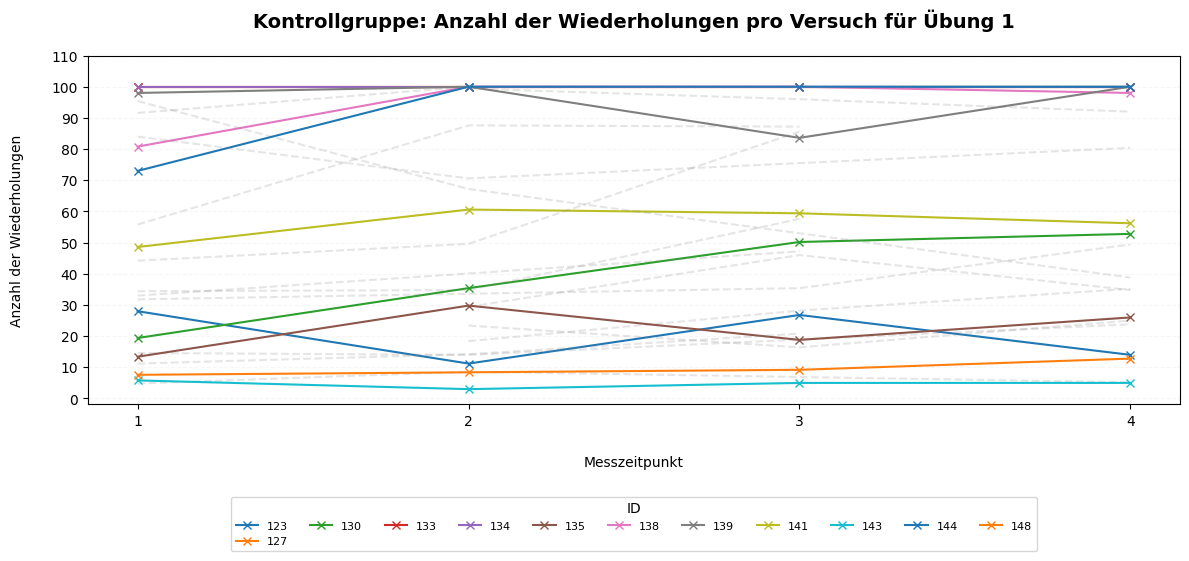

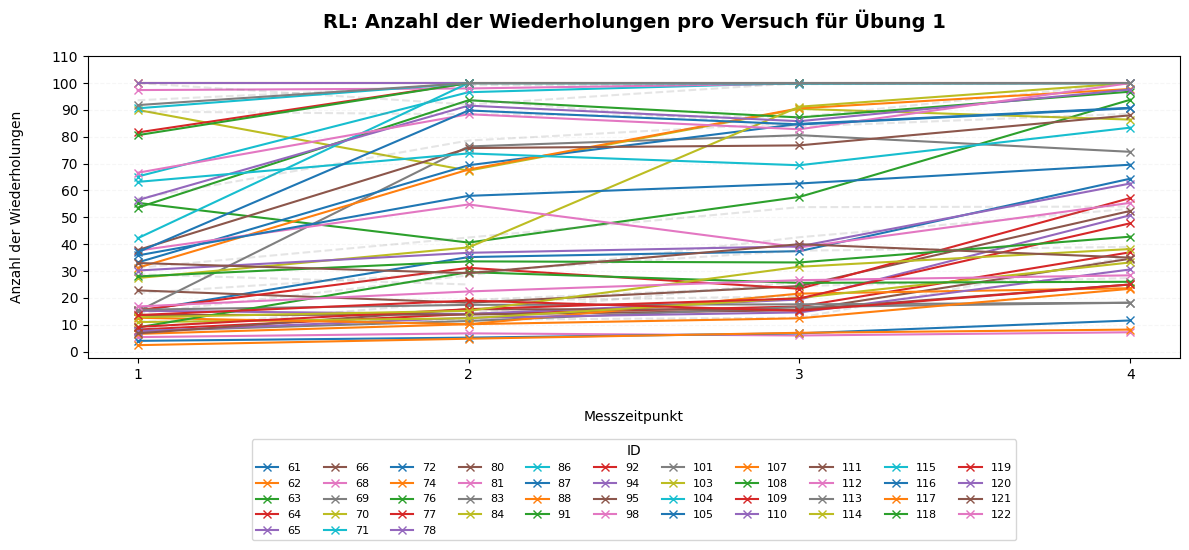

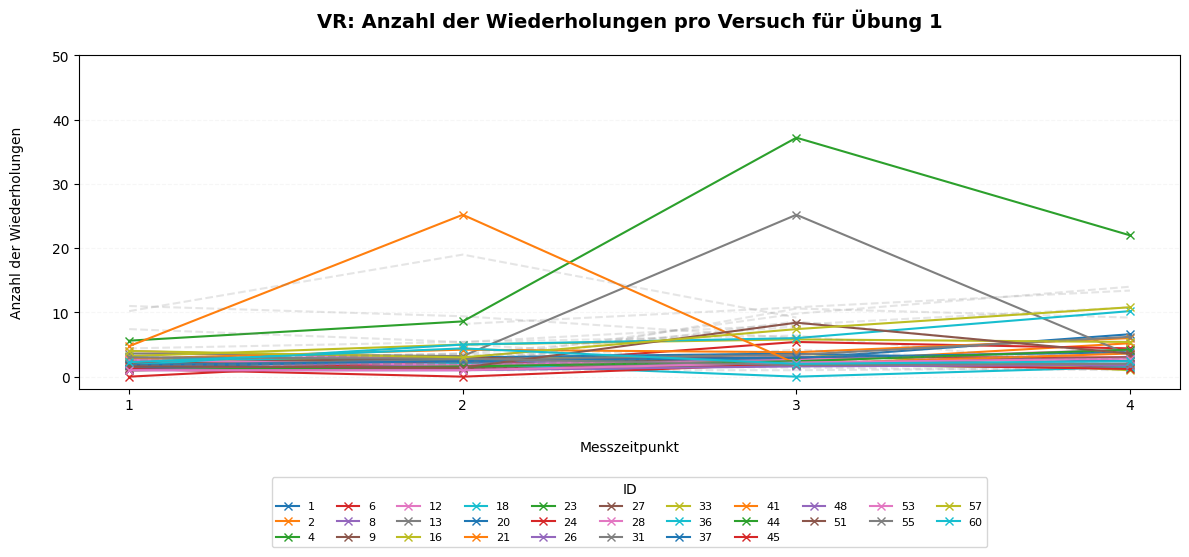

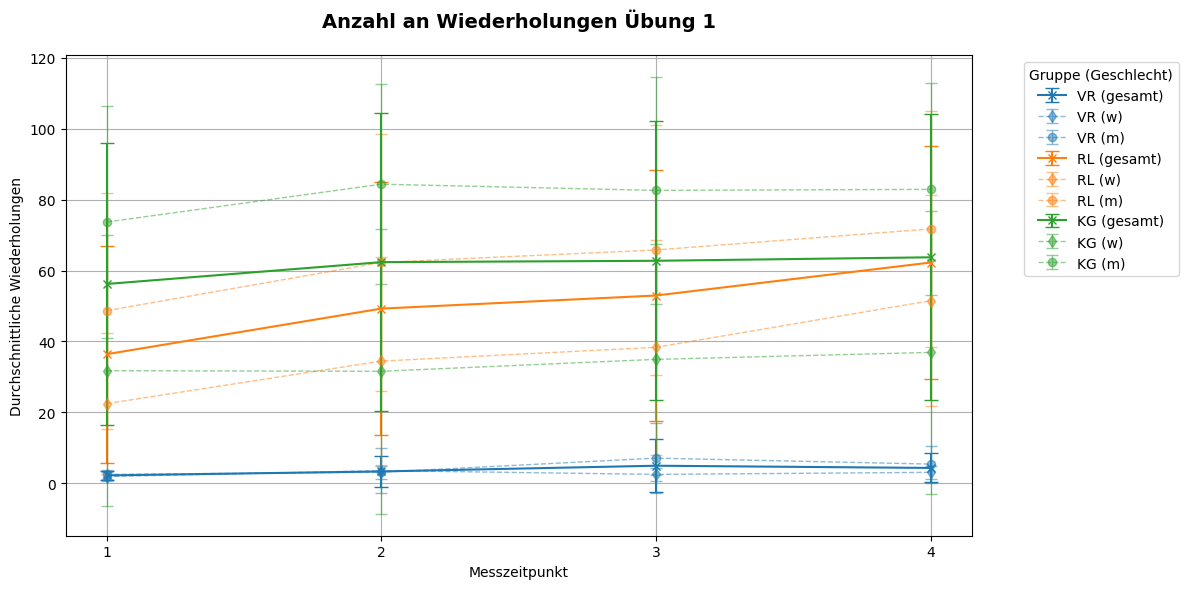

Processing group: kontrollgruppe sheet: 1
Processing group: RL 7e sheet: 1
Processing group: RL 7f sheet: 1
Processing group: VR sheet: 1
Unique IDs after loading:  59
VR (gesamt)
#Teilnehmer gesamt: 30
Messzeitpunkt 1: 1.146 +- 0.296
Messzeitpunkt 4: 1.4 +- 0.413
VR (w)
#Teilnehmer w: 14
Messzeitpunkt 1: 1.199 +- 0.232
Messzeitpunkt 4: 1.293 +- 0.352
VR (m)
#Teilnehmer m: 16
Messzeitpunkt 1: 1.1 +- 0.343
Messzeitpunkt 4: 1.494 +- 0.449
RL (gesamt)
#Teilnehmer gesamt: 47
Messzeitpunkt 1: 19.064 +- 21.319
Messzeitpunkt 4: 41.281 +- 33.762
RL (w)
#Teilnehmer w: 22
Messzeitpunkt 1: 11.718 +- 10.385
Messzeitpunkt 4: 31.855 +- 25.368
RL (m)
#Teilnehmer m: 25
Messzeitpunkt 1: 25.528 +- 26.148
Messzeitpunkt 4: 49.576 +- 38.321
KG (gesamt)
#Teilnehmer gesamt: 12
Messzeitpunkt 1: 39.683 +- 39.604
Messzeitpunkt 4: 45.867 +- 40.756
KG (w)
#Teilnehmer w: 5
Messzeitpunkt 1: 16.28 +- 24.157
Messzeitpunkt 4: 22.96 +- 28.459
KG (m)
#Teilnehmer m: 7
Messzeitpunkt 1: 56.4 +- 41.28
Messzeitpunkt 4: 62.22

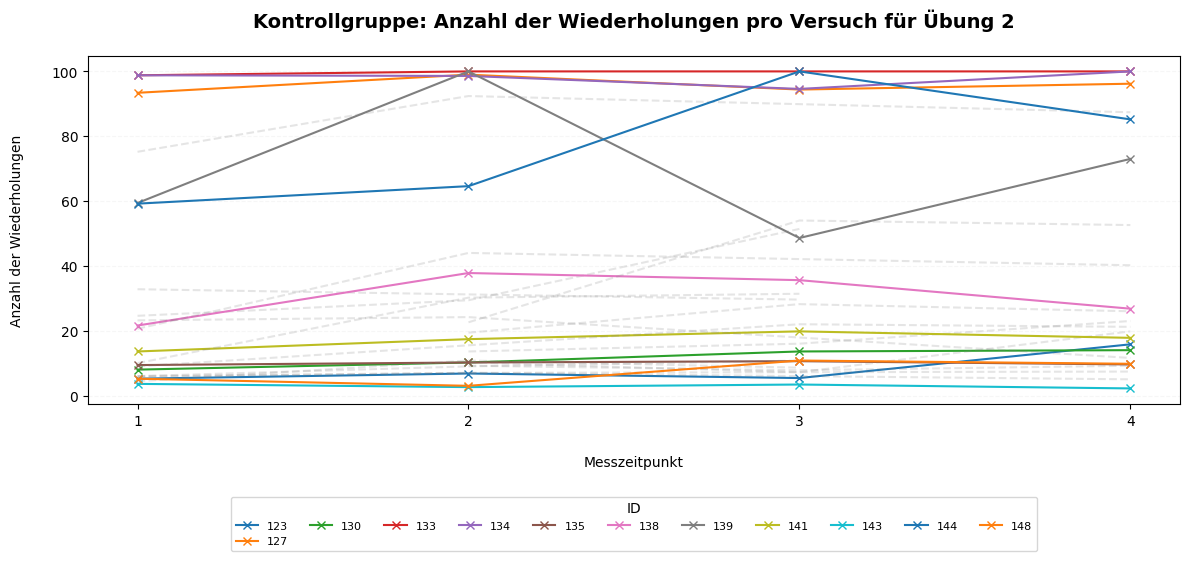

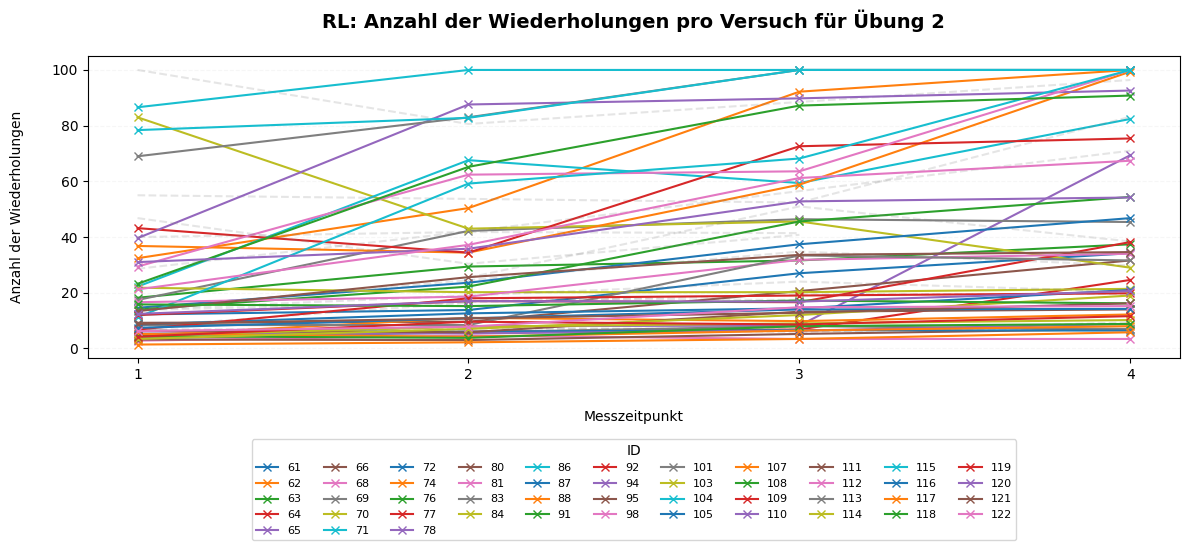

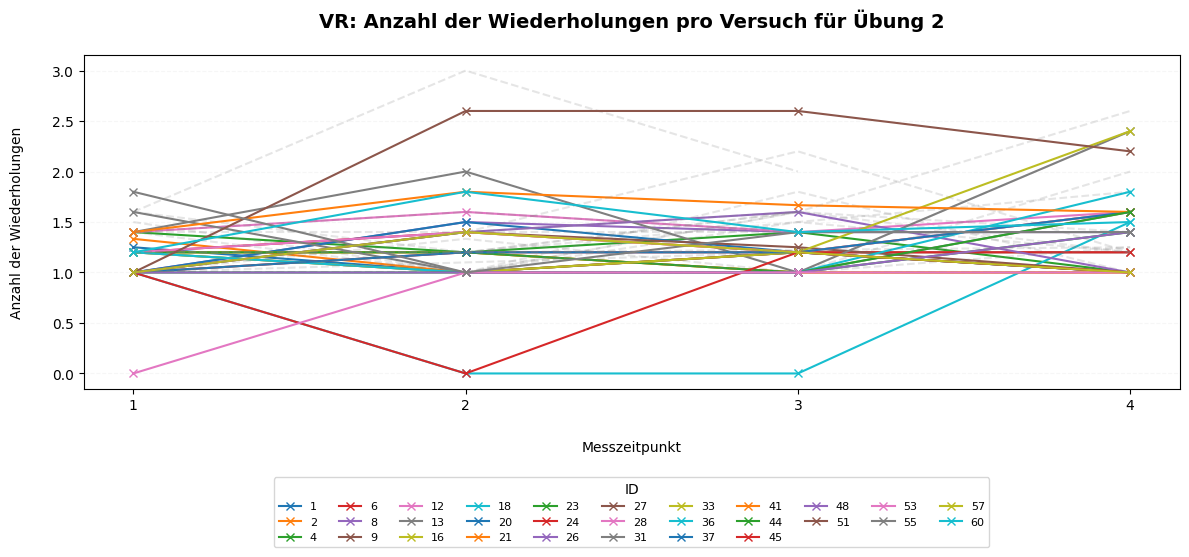

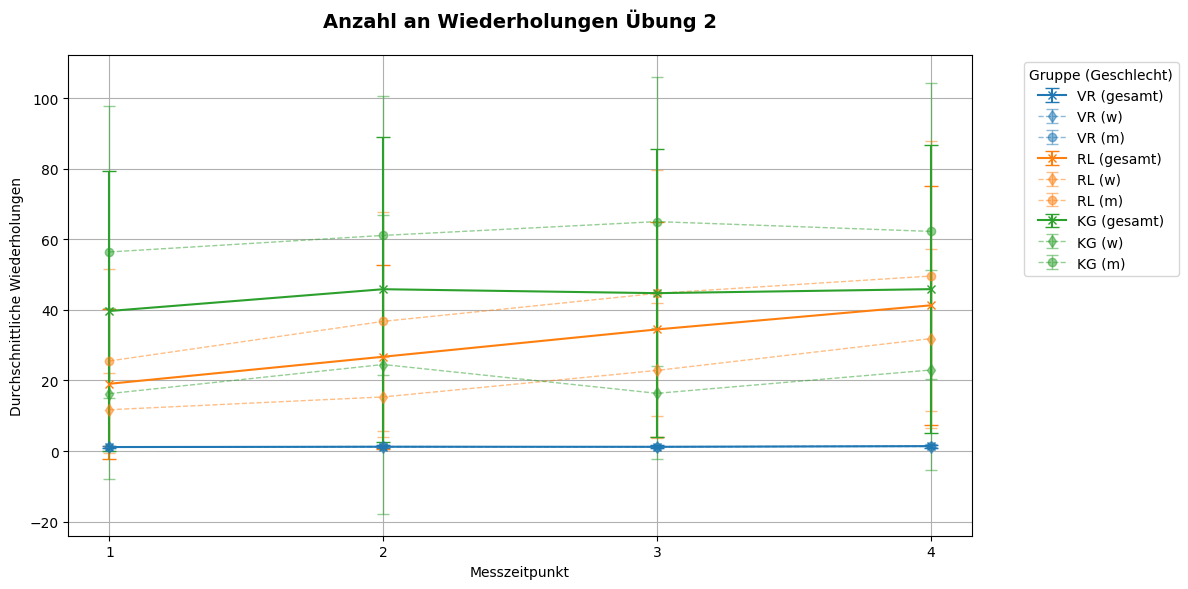

In [15]:
groups = ["kontrollgruppe", "RL 7e", "RL 7f", "VR"]
sheets = [0, 1]

for sheet in sheets:
    dfs = []
    for group in groups:
        print("Processing group:", group, "sheet:", sheet)
        if group == "VR":
            df_long = transform_VR_in_long(sheet)
        else:
            df = pd.read_excel(f"data/{group}.xlsx", sheet_name=sheet)

            # Anonymize the data
            df["Name"] = df["Name"].str.extract(r"\((\d+)\)")
            df = df.dropna(subset=["Name"])

            # make the long format
            df_long = make_long(df, group)
        #
        if "RL" in group:
            group_str = "RL"
        elif "VR" in group:
            group_str = "VR"
        else:
            group_str = "Kontrollgruppe"

        df_long["Group"] = group_str
        dfs.append(df_long)

    # Concatenate the second and last
    df_merged = pd.concat(dfs, ignore_index=True)
    df_merged = df_merged.reset_index(drop=True)

    # Load gender data: ID, gender
    df_gender = pd.read_csv("data/gender.csv")

    # add gender to the df
    df_merged = pd.merge(df_merged, df_gender, on="ID", how="left")

    # Save the concatenated DataFrame to a CSV file
    df_merged.to_csv(f"data/Exercise_{sheet + 1}_all.csv", index=False)

    df_valid = get_valid_ids(df_merged)
    df_valid.to_csv(f"data/Exercise_{sheet + 1}_valid.csv", index=False)

    plot_results(df_merged, sheet)
    plot_improvement_over_time(df_merged, sheet)
